# One dimensional implementations different packages

Import general packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Establish benchmark one-dimensional dataset

In [13]:
X = np.linspace(0,10,1000)
X_pred = X
X = np.random.choice(X, size = 10, replace = False, p = None)
y = X*np.sin(X)

## Compare different packages

scikit-learn

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [15]:
X = X.reshape(-1,1)

# Define kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

In [16]:
# Fit and predict
gp.fit(X, y)
y_pred, sigma = gp.predict(X, return_std=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


pykrige

In [17]:
%pip install pykrige

Note: you may need to restart the kernel to use updated packages.


In [18]:
from pykrige.ok import OrdinaryKriging

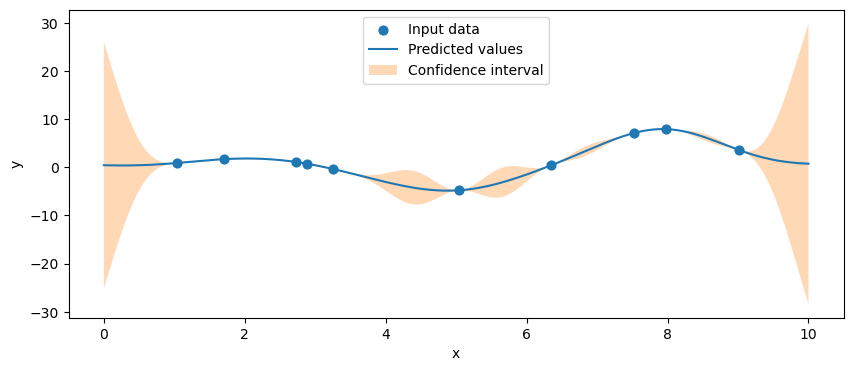

In [19]:
# Source: https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/05_kriging_1D.html
# pykrige doesn't support 1D data for now, only 2D or 3D
# adapting the 1D input to 2D

# plt.style.use("ggplot")

uk = OrdinaryKriging(X, np.zeros(X.shape), y, variogram_model="gaussian")

y_pred, y_std = uk.execute("grid", X_pred, np.array([0.0]))

y_pred = np.squeeze(y_pred)
y_std = np.squeeze(y_std)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.scatter(X, y, s=40, label="Input data")

ax.plot(X_pred, y_pred, label="Predicted values")
ax.fill_between(
    X_pred,
    y_pred - 3 * y_std,
    y_pred + 3 * y_std,
    alpha=0.3,
    label="Confidence interval",
)
ax.legend(loc=9)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

gpytorch

In [23]:
%pip install torch

  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl (209.8 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached triton-2.1.0-0-cp310-cp310-manylinux2014_x86_64.manylinux_

In [24]:
%pip install gpytorch

  Using cached gpytorch-1.11-py3-none-any.whl (266 kB)
  Using cached linear_operator-0.5.2-py3-none-any.whl (175 kB)
  Using cached jaxtyping-0.2.23-py3-none-any.whl (29 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
Note: you may need to restart the kernel to use updated packages.


In [22]:
import torch
import gpytorch

ModuleNotFoundError: No module named 'torch'

In [ ]:
# Convert data to PyTorch tensors
train_x = torch.tensor([1, 3, 5, 7, 9], dtype=torch.float32)
train_y = torch.tensor([1, 3, 1, 3, 1], dtype=torch.float32)

# Define GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Training is possible but for this basic example, we'll skip it

# Get predictions
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))
    y_pred = observed_pred.mean


MuyGPys  
https://github.com/LLNL/MuyGPyS